# Code pour le calcul de la déformée d'une barre 1D en traction/compression

## Présentation du problème 

On considère une poutre de longueur $L$ encastrée en $O$ ($u_0 = 0$), non pesante et soumise à un effort de traction traction compression $\underline{F}$ en $A$.     

### Approche énergétique

Ceci est un test LatexTrouver $$u \in C | a(u,v) = l(v) \quad v\in C_0$$
avec $$ C = \{u:x \in (0,L) \rightarrow u(x) \in \mathbb{R} | u(0) = 0 \}$$
et 
\begin{align}
a(u,v)& = \int_0^Lu'(x)v'(x)ES \text{d}x
\end{align}

## Hypothèses de modélisation
- Modélisation 1D : Les éléments du maillage de la barre sont des éléments <span style='color:red'> B2 </span>
- Les éléments ainsi que les noeuds sont rangés dans l'ordre croissant 
- Les éléments sont tous identiques et d'ordre 1 (fonction de forme linéaire)

## Avertissement 
Les hypothèses de modélisation impliquent que le code présenté est utilisable exclusivement au problème traité. Certaines strcutures de code employées ne conviendront pas aux problèmes aux caractéristiques suivantes :
- Code pour modèle 2D/3D 
    - avec plus d'un DDL par noeud 
    - des éléments 2D
    - organisation des noeuds (qui nécessiterait de faire la correspondance coordonnée locale/globale des noeuds
- Emploi d'éléments différents (qui nécessiterait la transformation d'éléments de référence caractérisée par la matrice <span style='color:red'> Jacobienne </span>)
    

## Améliorations
Ci-dessous la liste des améliorations à apporter au code pour étoffer la méthode de résolution et ainsi couvrir plus de configurations : 
- Améliorer la création de la variable `nddlconnus` par lecture du problème
- Détecter les ddls des CLs sans avoir à les indiquer manuellement

# Code par la méthode des éléments finis

#### Importation des packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interactive 

#### Variables

In [2]:
# Taille de la barre (en m)
L = 2.
# Section de la poutre (en m²)
S = 0.005
# Masse volumique de la barre (aluminium) (kg/m³)
rho = 2800.
# Module de Young de l'aluminium (Pa/m²)
E = 70e9
# Force appliquée (en N)
force = 150e3

#### Maillage

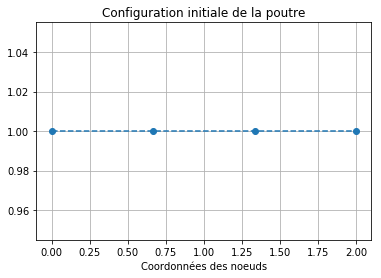

[ 0.          0.66666667  1.33333333  2.        ]


In [3]:
# Nombre d'éléments
NE = 3.
# Nombre de noeuds
NN = int(NE+1)
# Taille d'un élément
h = float(L/NE)
# CCL en déplacement au(x) neud(s) encastré(s)
u_impose = np.array([[0]])
# Nombre de DDLs liés aux CLs
nddlconnus = u_impose.shape[0]
# Vecteur coordonnées des noeuds (NN x 1)
# coor = np.arange(0,L+h,h) <--- Peut présenter des bugs à cause de la précision des floats
coor = np.linspace(0,L,NN)

y = np.linspace(1, 1, NN)
plt.plot(coor, y, '--o')
plt.xlabel('Coordonnées des noeuds')
plt.title("Configuration initiale de la poutre")
plt.grid()
#plt.legend()
plt.show()

print(coor)

#### Initialisation

In [4]:
# Initialisation --- Matrice de raideur totale (NN x NN)
K = np.zeros((NN,NN))
# Initialisation --- Vecteur de force totale (NN x 1)
F = np.zeros((NN,1))
# Traction simple
F[-1] = -force

#### Création de la matrice de raideur `[K]`
Tout d'abord considérons la fonction `Calcul_Ke`. Cette fonction génère la matrice de raideur d'un élément dont les nœuds sont donnés en argument. Sont également à indiquer le module de Young `E` et la section `S` de la poutre considérée.
Cette fonction ne calcule que les matrices de raideur élémentaire des éléments _poutres-2D_. 

In [5]:
def Calcul_Ke(c,moduledeYoung,surface):
	""" liste de float, float --> matrice
		hypothèse : coordonnees de dimension 2
		Retourne la matrice de raideur élémentaire """

	# Extraction des coordonnées
	x0 = c[0]
	x1 = c[1]

	# Longueur élément 
	# Information nécessaire pour les éléments réels car la norme de ces derniers n'est pas normalisée 
	# Voir fonction de formme pour les éléments "non de référence"
	l = x1-x0

	# Surface non prise en compte si poutre non pesante
	Ke = (moduledeYoung*surface/l)*np.array([[1,-1],[-1,1]])
	
	return Ke

#### Assemblage de la matrice de raideur

In [6]:
for i in (np.arange(int(NE))):
    coor_element = coor[i:((i+1)+1)] # +1 car python fonctionne sur les "coupes" entre les éléments d'une liste
    
    # Matrice de raideur élémentaire
    Ke = Calcul_Ke(coor_element,E,S)
    # Assemblage de K pénalisé 
    K[i:i+2,i:i+2] = K[i:i+2,i:i+2]+ Ke

In [7]:
if NE <= 3:
    print('Matrice de raideur K non pénalisée : \n',K)

Matrice de raideur K non pénalisée : 
 [[  5.25000000e+08  -5.25000000e+08   0.00000000e+00   0.00000000e+00]
 [ -5.25000000e+08   1.05000000e+09  -5.25000000e+08   0.00000000e+00]
 [  0.00000000e+00  -5.25000000e+08   1.05000000e+09  -5.25000000e+08]
 [  0.00000000e+00   0.00000000e+00  -5.25000000e+08   5.25000000e+08]]


#### Prise en compte des CLs : Méthode des _multiplicateurs de Lagrange_
On augmente la taille du système linéaire afin de prendre en compte les conditions aux limites imposées par l'encastrement : $u(x=0) = u_0 ^{(1)} = 0$.

On génère la matrice de position **[C]**. La matrice est pleine de zéros et les composantes multiplicatives des DDLs connus de {U} dans le système **[C]{U}={0}** sont égales à 1.

L'objectif est de créer le  système linéaire augmenté suivant : 
$$ 
\begin{bmatrix}
[K] & [C]^T\\
[C] & [0]
\end{bmatrix} 
\begin{Bmatrix}
U\\
\lambda
\end{Bmatrix}
=
\begin{Bmatrix}
F\\
U^d
\end{Bmatrix}
$$

avec
- $\{ \lambda \}$ : Coefficients de Lagrange
- $\{U^d\}$ : Les déplacements connus

Pour générer **[K$_{augmenté}$]**, on ajoute **[C]** puis **[C]$^T$**

In [8]:
# Initialisation
c = np.zeros((nddlconnus,NN))
# Remplissage : ddl 0 (premier  + direction x est encastré)
c[:,0:nddlconnus] = 1
cT = np.transpose(c)
ctransp = np.zeros((NN+nddlconnus,nddlconnus))
ctransp[0:NN,0:nddlconnus] = cT
# Assemblage
K = np.append(K,c,axis=0) 
K = np.append(K,ctransp,axis=1) # On a K augmenté
F = np.append(F,u_impose,axis=0) # On a F augmenté

In [9]:
if NE<=3: 
    print('Matrice C : \n',c)
    print('\n Membre de gauche : \n',F)

Matrice C : 
 [[ 1.  0.  0.  0.]]

 Membre de gauche : 
 [[      0.]
 [      0.]
 [      0.]
 [-150000.]
 [      0.]]


#### Résolution 
On procède finalement à la résolutio du système. La méthode des multiplicateurs de Lagrande ne permet pas l'emploi de méthode de résolution "classique" (LU, gradient, Cholesky) car bien qu'inversible, **[K$_{augmenté}$]** n'est pas définie positive.

U = 
 [[ -1.10871735e-19]
 [ -2.85714286e-04]
 [ -5.71428571e-04]
 [ -8.57142857e-04]]


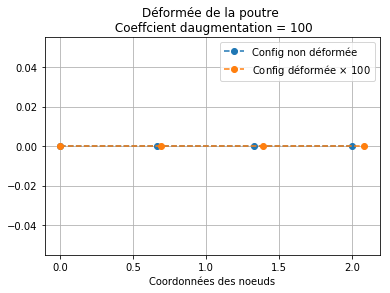

In [13]:
U_aug = np.linalg.solve(K,F)
U = U_aug[0:NN]
Coefflagrange = U_aug[NN:NN+nddlconnus]
print('U = \n', U)

coeff_augm = 100. # coefficient d'augmentation pour la visualisation
coor2 = np.sqrt((coor-np.transpose(coeff_augm*U[:,0]))**2)
y = np.linspace(0, 0, NN)
plt.plot(coor, y, '--o',coor2,y,'--o')
plt.xlabel('Coordonnées des noeuds')
plt.title('Déformée de la poutre \n Coeffcient d''augmentation = %d' %(coeff_augm))
plt.grid()
plt.legend(['Config non déformée','Config déformée'
            r' $\times $ %d' %coeff_augm])
plt.show()